# DOWNLOADING THE DATASET

In [1]:
#downloading the datasets
import os
import opendatasets as od

url = 'https://kaggle.com/competitions/store-sales-time-series-forecasting'
od.download(url)

Skipping, found downloaded files in ".\store-sales-time-series-forecasting" (use force=True to force download)


In [2]:
os.listdir('store-sales-time-series-forecasting')#listing datasets directories

['holidays_events.csv',
 'oil.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

In [3]:
#importing modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import calendar
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor
offline.init_notebook_mode(connected = True)

C:\Users\hp\.conda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# LOADING THE DATSETS

In [4]:
#reading the datasets
holiday = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('store-sales-time-series-forecasting/oil.csv')
sub = pd.read_csv('store-sales-time-series-forecasting/sample_submission.csv')
store = pd.read_csv('store-sales-time-series-forecasting/stores.csv')
test = pd.read_csv('store-sales-time-series-forecasting/test.csv')
train = pd.read_csv('store-sales-time-series-forecasting/train.csv')
transact = pd.read_csv('store-sales-time-series-forecasting/transactions.csv')

In [5]:
#Calling a basic_info function to get the summary of the data 
def basic_info(holiday):
    dup = holiday.duplicated().sum().any()
    dtype = holiday.dtypes
    null = holiday.isna().sum().any()
    total_missing = holiday.isnull().sum().sum()
    shapes = holiday.shape
    return f"Duplicates: {dup}\n{dtype}\nHave null values: {null}\nMissing values: {total_missing}\nShapes: {shapes}"

print(basic_info(holiday))

Duplicates: False
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object
Have null values: False
Missing values: 0
Shapes: (350, 6)


In [6]:
print(basic_info(oil))

Duplicates: False
date           object
dcoilwtico    float64
dtype: object
Have null values: True
Missing values: 43
Shapes: (1218, 2)


In [7]:
print(basic_info(sub))

Duplicates: False
id         int64
sales    float64
dtype: object
Have null values: False
Missing values: 0
Shapes: (28512, 2)


In [8]:
print(basic_info(store))

Duplicates: False
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object
Have null values: False
Missing values: 0
Shapes: (54, 5)


In [9]:
print(basic_info(transact))

Duplicates: False
date            object
store_nbr        int64
transactions     int64
dtype: object
Have null values: False
Missing values: 0
Shapes: (83488, 3)


In [10]:
print(basic_info(train))

Duplicates: False
id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object
Have null values: False
Missing values: 0
Shapes: (3000888, 6)


In [11]:
print(basic_info(test))

Duplicates: False
id              int64
date           object
store_nbr       int64
family         object
onpromotion     int64
dtype: object
Have null values: False
Missing values: 0
Shapes: (28512, 5)


In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1.500444e+06,866281.891642,0.0,750221.75,1500443.5,2.250665e+06,3000887.0
store_nbr,3000888.0,2.750000e+01,15.585787,1.0,14.00,27.5,4.100000e+01,54.0
sales,3000888.0,3.577757e+02,1101.997721,0.0,0.00,11.0,1.958473e+02,124717.0
onpromotion,3000888.0,2.602770e+00,12.218882,0.0,0.00,0.0,0.000000e+00,741.0


In [13]:
#dataset summary
fig=go.Figure()
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3],
    y=[1.6, 1.6, 1.6, 1.6],
    mode="text", 
    text=["<span style='font-size:33px'><b>54</b></span>", 
          "<span style='font-size:33px'><b>33</b></span>",
          "<span style='font-size:33px'><b>16</b></span>",
          "<span style='font-size:33px'><b>56</b></span>"],
    textposition="bottom center"
))
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3],
    y=[1.1, 1.1, 1.1, 1.1],
    mode="text", 
    text=["Stores", "Products", "States", "Months"],
    textposition="bottom center"
))
fig.add_hline(y=2.2, line_width=5, line_color='gray')
fig.add_hline(y=0.3, line_width=3, line_color='gray')
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=False, height=300, width=700, 
                  title='Store Sales Summary', title_x=0.5, title_y=0.9,
                  xaxis_range=[-0.5,3.6], yaxis_range=[-0.2,2.2],
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  font=dict(size=23, color='#323232'),
                  title_font=dict(size=35, color='#222'),
                  margin=dict(t=90,l=70,b=0,r=70), 
    )

In [14]:
# merging a copy of train data on other datasets for analysis
train1 = train.merge(holiday, on = 'date', how='left')
train1 = train1.merge(oil, on = 'date', how='left')
train1 = train1.merge(store, on = 'store_nbr', how='left')
train1 = train1.merge(transact, on = ['date', 'store_nbr'], how='left')
train1 = train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

train1['date'] = pd.to_datetime(train1['date'])
train1['year'] = train1['date'].dt.year
train1['month'] = train1['date'].dt.month
train1['week'] = train1['date'].dt.isocalendar().week
train1['quarter'] = train1['date'].dt.quarter
train1['day_of_week'] = train1['date'].dt.day_name()
train1[:5]

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,...,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday


In [15]:
train1.columns#getting columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico', 'city', 'state', 'store_type', 'cluster', 'transactions',
       'year', 'month', 'week', 'quarter', 'day_of_week'],
      dtype='object')

In [16]:
train1.describe().T#analysis

,count,mean,std,min,25%,50%,75%,max
id,3054348.0,1504276.775379,866261.012008,0.0,754676.75,1507571.5,2255120.25,3000887.0
store_nbr,3054348.0,27.5,15.585787,1.0,14.0,27.5,41.0,54.0
sales,3054348.0,359.020892,1107.285897,0.0,0.0,11.0,196.011,124717.0
onpromotion,3054348.0,2.61748,12.254939,0.0,0.0,0.0,0.0,741.0
dcoilwtico,2099196.0,68.015874,25.691342,26.19,46.41,53.43,95.81,110.62
cluster,3054348.0,8.481481,4.649735,1.0,4.0,8.5,13.0,17.0
transactions,2805231.0,1697.071441,966.831652,5.0,1046.0,1395.0,2081.0,8359.0
year,3054348.0,2014.842474,1.345607,2013.0,2014.0,2015.0,2016.0,2017.0
month,3054348.0,6.22287,3.374251,1.0,3.0,6.0,9.0,12.0
week,3054348.0,25.308635,14.750509,1.0,13.0,25.0,38.0,53.0


# EXPLORATARY DATA ANALYSIS

In [17]:
# Sales analysis
df_st_sa = train1.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_fa_sa = train1.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_cl_sa = train1.groupby('cluster').agg({"sales" : "mean"}).reset_index() 
# chart color
df_fa_sa['color'] = '#496595'
df_fa_sa['color'][2:] = '#c6ccd8'
df_cl_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 Highest Product Sales", "Highest Sales in Stores", "Clusters Vs Sales"))

fig.add_trace(go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'], marker=dict(color= df_fa_sa['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_st_sa['sales'], labels=df_st_sa['store_type'], name='Store type',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=df_cl_sa['cluster'], y=df_cl_sa['sales'], 
                     marker=dict(color= df_cl_sa['color']), name='Cluster'), 
                     row=2, col=1)

# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_cl_sa.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

In [18]:
# Sales across the years NOTE no data for year 2017
df_2013 = train1[train1['year']==2013][['month','sales']]
df_2013 = df_2013.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s13'})
df_2014 = train1[train1['year']==2014][['month','sales']]
df_2014 = df_2014.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s14'})
df_2015 = train1[train1['year']==2015][['month','sales']]
df_2015 = df_2015.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s15'})
df_2016 = train1[train1['year']==2016][['month','sales']]
df_2016 = df_2016.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s16'})
df_2017 = train1[train1['year']==2017][['month','sales']]
df_2017 = df_2017.groupby('month').agg({"sales" : "mean"}).reset_index()
df_2017_no = pd.DataFrame({'month': [9,10,11,12], 'sales':[0,0,0,0]})
df_2017 = df_2017.append(df_2017_no).rename(columns={'sales':'s17'})
df_year = df_2013.merge(df_2014,on='month').merge(df_2015,on='month').merge(df_2016,on='month').merge(df_2017,on='month')

# top levels
top_labels = ['2013', '2014', '2015', '2016', '2017']

colors = ['rgba(38, 24, 74, 0.8)', 'rgba(71, 58, 131, 0.8)',
          'rgba(122, 120, 168, 0.8)', 'rgba(164, 163, 204, 0.85)',
          'rgba(190, 192, 213, 1)']

# X axis value 
df_year = df_year[['s13','s14','s15','s16','s17']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_2013['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_2013['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(title='Avg Sales for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_4636\489917448.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [19]:
# Trend wise by months and weeks 
df_m_sa = train1.groupby('month').agg({"sales" : "mean"}).reset_index()
df_m_sa['sales'] = round(df_m_sa['sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['sales'].astype(str) 

df_w_sa = train1.groupby('week').agg({"sales" : "mean"}).reset_index() 
df_q_sa = train1.groupby('quarter').agg({"sales" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis", 
                                    "Week wise Avg Sales Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

In [20]:
# Average sales by day
df_dw_sa = train1.groupby('day_of_week').agg({"sales" : "mean"}).reset_index()
df_dw_sa.sales = round(df_dw_sa.sales, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='sales', title='Avg Sales vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='sales',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

In [21]:
# Average sales by store and holiday
df_st_ht = train1.groupby(['store_type','holiday_type']).agg({"sales" : "mean"}).reset_index()
df_st_ht['sales'] = round(df_st_ht['sales'], 2)

# chart
fig = px.scatter(df_st_ht, x='store_type', color='sales', y='holiday_type', size='sales',
                 color_discrete_sequence=px.colors.qualitative.D3,
                 title="Average Sales: Store Type Vs Holiday Type")
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_layout(height=400, xaxis_title='', yaxis_title='',
                  margin=dict(b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

In [22]:
# Average sales store by year, months
df_y_m_st = train1.groupby(['year','month','store_type']).agg({"sales" : "mean"}).reset_index()
df_y_m_st['sales'] = round(df_y_m_st['sales'], 2)

# chart
fig = px.scatter(df_y_m_st, x='month', y='store_type', color='sales', size='sales', 
                 facet_row='year', title='Average Sales: Store Type Vs Year(Month)')
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=900, xaxis_title='', yaxis_title='',
                  margin=dict(t=70, b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

In [23]:
# Average sale by holiday type
df_m_ht = train1.groupby(['month','holiday_type']).agg({"sales" : "mean"}).reset_index()
df_m_ht['sales'] = round(df_m_ht['sales'], 2)

# chart
fig = px.scatter(df_m_ht, x='month', color='sales', y='holiday_type', size='sales',
                 color_discrete_sequence=px.colors.qualitative.D3,
                 title="Average Sales: Month Vs Holiday Type")
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=400, xaxis_title='', yaxis_title='',
                  margin=dict(b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

In [24]:
#  Average sale by holiday type, month and year
df_y_m_ht = train1.groupby(['year','month','holiday_type']).agg({"sales" : "mean"}).reset_index()
df_y_m_ht['sales'] = round(df_y_m_ht['sales'], 2)

# chart
fig = px.scatter(df_y_m_ht, x='month', y='holiday_type', color='sales', size='sales', 
                 facet_row='year', title='Average Sales: Holiday_type Vs Year(Month)')
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=900, xaxis_title='', yaxis_title='',
                  margin=dict(t=70, b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

 The above visualiztions was gotten from **KASHISH RASTOGI** 📝Store Sales Analysis⏳ Time Serie notebook on this same competition BIG credit to her nice codes which i just made some little changes to  ·

# FEATURE ENGINEERING

In [25]:
#getting the train test dataset
train[:5], test[:5]

(   id        date  store_nbr      family  sales  onpromotion
 0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
 1   1  2013-01-01          1   BABY CARE    0.0            0
 2   2  2013-01-01          1      BEAUTY    0.0            0
 3   3  2013-01-01          1   BEVERAGES    0.0            0
 4   4  2013-01-01          1       BOOKS    0.0            0,
         id        date  store_nbr      family  onpromotion
 0  3000888  2017-08-16          1  AUTOMOTIVE            0
 1  3000889  2017-08-16          1   BABY CARE            0
 2  3000890  2017-08-16          1      BEAUTY            2
 3  3000891  2017-08-16          1   BEVERAGES           20
 4  3000892  2017-08-16          1       BOOKS            0)

In [26]:
#calling the set_date_time function
def set_date_time(train):
    train['date'] = pd.to_datetime(train['date'])
    train['year'] = train['date'].dt.year
    train['month'] = train['date'].dt.month
    train['day'] = train['date'].dt.day
    return train

set_date_time(train).dtypes, set_date_time(test).dtypes

(id                      int64
 date           datetime64[ns]
 store_nbr               int64
 family                 object
 sales                 float64
 onpromotion             int64
 year                    int64
 month                   int64
 day                     int64
 dtype: object,
 id                      int64
 date           datetime64[ns]
 store_nbr               int64
 family                 object
 onpromotion             int64
 year                    int64
 month                   int64
 day                     int64
 dtype: object)

<Axes: xlabel='year', ylabel='sales'>

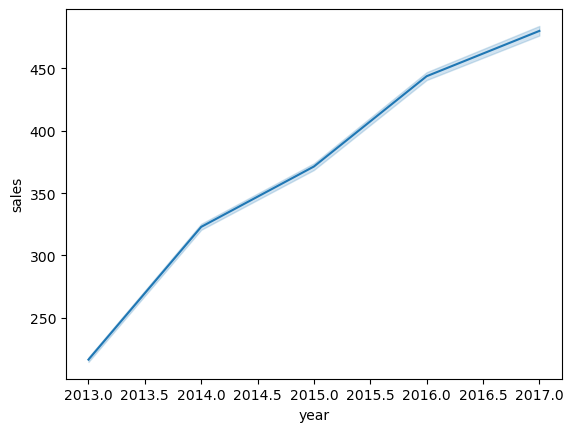

In [27]:
sns.lineplot(train, x='year', y='sales')

In [28]:
#Encoding the dataset
encoder = LabelEncoder()
train['family'] = encoder.fit_transform(train['family'])
train.tail(2)

#repeat for test dataset
test['family'] = encoder.fit_transform(test['family'])
train.tail(2), test.head(2)

(              id       date  store_nbr  family  sales  onpromotion  year  \
 3000886  3000886 2017-08-15          9      31  121.0            8  2017   
 3000887  3000887 2017-08-15          9      32   16.0            0  2017   
 
          month  day  
 3000886      8   15  
 3000887      8   15  ,
         id       date  store_nbr  family  onpromotion  year  month  day
 0  3000888 2017-08-16          1       0            0  2017      8   16
 1  3000889 2017-08-16          1       1            0  2017      8   16)

In [29]:
#feature columns
column = ['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day']
X = train[column]
X.head()

,store_nbr,family,onpromotion,year,month,day
0,1,0,0,2013,1,1
1,1,1,0,2013,1,1
2,1,2,0,2013,1,1
3,1,3,0,2013,1,1
4,1,4,0,2013,1,1


In [30]:
#scaling
scala = StandardScaler()
X = scala.fit_transform(X)
X

array([[-1.70026736, -1.6803361 , -0.21301217, -1.36593241, -1.5382016 ,
        -1.66349071],
       [-1.70026736, -1.57531509, -0.21301217, -1.36593241, -1.5382016 ,
        -1.66349071],
       [-1.70026736, -1.47029409, -0.21301217, -1.36593241, -1.5382016 ,
        -1.66349071],
       ...,
       [-1.1869791 ,  1.47029409, 11.89939062,  1.60690143,  0.52933779,
        -0.07163874],
       [-1.1869791 ,  1.57531509,  0.4417123 ,  1.60690143,  0.52933779,
        -0.07163874],
       [-1.1869791 ,  1.6803361 , -0.21301217,  1.60690143,  0.52933779,
        -0.07163874]])

In [31]:
#target 
y = train.sales
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: sales, dtype: float64

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=20)#splitting to training and validation sets

In [33]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape #getting the shapes

((2250666, 6), (2250666,), (750222, 6), (750222,))

# MODELLING

In [34]:
 #modelling
# Define the hyperparameter grid
param_grid = {
    'max_depth': [1, 1000, 3],
    'learning_rate': [0.3, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor(random_state=20, parameter=param_grid, n_estimators=300)

# Fit the model object to the training data
xgb_model.fit(X_train, y_train)

C:\Users\hp\.conda\Lib\site-packages\xgboost\core.py:160: UserWarning:

[11:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "parameter" } are not used.




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None,
             parameter={'learning_rate': [0.3, 0.01, 0.001],
                        'max_depth': [1, 1000, 3], 'subsample': [0.5, 0.7, 1]}, ...)

In [35]:
xgb_pred = xgb_model.predict(X_val)
squared_log_errors = (np.log1p(y_val) - np.log1p(xgb_pred)) ** 2
mean_squared_log_error = np.mean(squared_log_errors)
rmsle = np.sqrt(mean_squared_log_error)
print("RMSLE:", rmsle)

RMSLE: 1.8611422249112664


C:\Users\hp\AppData\Local\Temp\ipykernel_4636\4012739418.py:2: RuntimeWarning:

invalid value encountered in log1p



In [36]:
#using catboost
best_params = {
            'bagging_temperature': 0.5,
            'depth': 15,
            'iterations': 10,
            'l2_leaf_reg': 25,
            'learning_rate': 0.5,
            'sampling_frequency': 'PerTreeLevel',
            'leaf_estimation_method': 'Gradient',
            'random_strength': 20,
            'boosting_type': 'Ordered',
            'feature_border_type': 'MaxLogSum',
            'l2_leaf_reg': 50,
            'max_ctr_complexity': 2,
            'fold_len_multiplier': 2
    }

model_cat = CatBoostRegressor(**best_params,
                               thread_count=8,
                               task_type='CPU',
                               verbose=True)


model_cat.fit(X_train, y_train)

0:	learn: 811.8448742	total: 11.5s	remaining: 1m 43s
1:	learn: 704.0866223	total: 24s	remaining: 1m 36s
2:	learn: 656.6385628	total: 26.8s	remaining: 1m 2s
3:	learn: 609.8526506	total: 37.2s	remaining: 55.7s
4:	learn: 605.7680737	total: 38.6s	remaining: 38.6s
5:	learn: 584.4705119	total: 48.9s	remaining: 32.6s
6:	learn: 565.9401891	total: 59.1s	remaining: 25.3s
7:	learn: 553.6044045	total: 1m 1s	remaining: 15.3s
8:	learn: 538.1443815	total: 1m 11s	remaining: 7.97s
9:	learn: 533.2124409	total: 1m 22s	remaining: 0us


In [37]:
cat_pred = model_cat.predict(X_val)
squared_log_errors = (np.log1p(y_val) - np.log1p(cat_pred)) ** 2
mean_squared_log_error = np.mean(squared_log_errors)
rmsle = np.sqrt(mean_squared_log_error)
print("RMSLE:", rmsle)

RMSLE: 2.566363884686207


C:\Users\hp\AppData\Local\Temp\ipykernel_4636\1105860578.py:2: RuntimeWarning:

invalid value encountered in log1p



In [38]:
# using the xgb model on the test data
test_pred = test[column]
test_pred[-5:]

,store_nbr,family,onpromotion,year,month,day
28507,9,28,1,2017,8,31
28508,9,29,0,2017,8,31
28509,9,30,1,2017,8,31
28510,9,31,9,2017,8,31
28511,9,32,0,2017,8,31


In [39]:
test_pred = scala.fit_transform(test_pred)
test_pred

array([[-1.70026736, -1.6803361 , -0.33675892,  0.        ,  0.        ,
        -1.62697843],
       [-1.70026736, -1.57531509, -0.33675892,  0.        ,  0.        ,
        -1.62697843],
       [-1.70026736, -1.47029409, -0.2400639 ,  0.        ,  0.        ,
        -1.62697843],
       ...,
       [-1.1869791 ,  1.47029409, -0.28841141,  0.        ,  0.        ,
         1.62697843],
       [-1.1869791 ,  1.57531509,  0.09836866,  0.        ,  0.        ,
         1.62697843],
       [-1.1869791 ,  1.6803361 , -0.33675892,  0.        ,  0.        ,
         1.62697843]])

In [40]:
prediction = xgb_model.predict(test_pred)#prediction
prediction

array([  14.741883,   11.743788,   13.05485 , ...,  316.40112 ,
       -164.86412 ,  -58.051693], dtype=float32)

In [41]:
sub = pd.read_csv('store-sales-time-series-forecasting/sample_submission.csv')
submission = sub
submission[:2]

,id,sales
0,3000888,0.0
1,3000889,0.0


In [42]:
submission['sales'] = prediction
submission[:10]

,id,sales
0,3000888,14.741883
1,3000889,11.743788
2,3000890,13.054850
3,3000891,537.979797
4,3000892,-3.987240
5,3000893,611.635986
6,3000894,32.395714
7,3000895,1167.539429
8,3000896,2054.961670
9,3000897,540.147156


<Axes: xlabel='sales', ylabel='Density'>

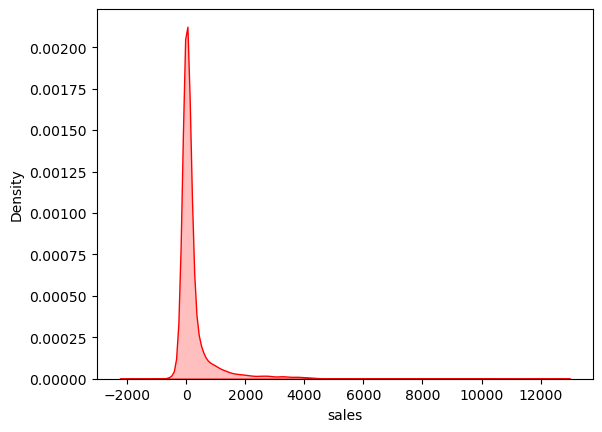

In [43]:
sns.kdeplot(submission, x='sales', fill=True, color='red')

In [44]:
submission.to_csv('submission.csv', index=False)